### Example

# RRCF-Power

## Import and Reshape Data

In [31]:
import pandas as pd
data_source_path = 'rrcf_power/data/sample-1H.csv'
df_raw = pd.read_csv(data_source_path)
df_raw.head()

,Unnamed: 0,date,category,value
0,1,2019-09-01 12:00:00,A,17
1,2,2019-09-01 12:00:00,B,6
2,3,2019-09-01 12:00:00,C,7
3,4,2019-09-01 13:00:00,A,23
4,5,2019-09-01 13:00:00,B,1


In [2]:
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [3]:
df_currated = df_raw.copy()
df_currated.drop_duplicates(subset=['date'], inplace=True)
df_currated.set_index('date', inplace=True)
df_currated.head()

,Unnamed: 0,category,value
date,,,
2019-09-01 12:00:00,1,A,17
2019-09-01 13:00:00,4,A,23
2019-09-01 14:00:00,7,A,17
2019-09-01 15:00:00,10,A,15
2019-09-01 16:00:00,13,A,15


In [4]:
for category, col_name in zip(['A', 'B', 'C'], ['unit_a', 'unit_b', 'unit_c']):
    df_temp = df_raw[df_raw['category']==category].copy()
    df_temp.drop_duplicates(subset=['date'], inplace=True)
    df_temp.set_index('date', inplace=True)
    df_temp.drop(['category', 'Unnamed: 0'], axis=1, inplace=True)
    df_temp.rename(columns={'value':col_name}, inplace=True)
    df_currated[col_name] = df_temp
df_currated.drop(['Unnamed: 0', 'category', 'value'], axis=1, inplace=True)
df_currated

,unit_a,unit_b,unit_c
date,,,
2019-09-01 12:00:00,17,6.0,7.0
2019-09-01 13:00:00,23,1.0,6.0
2019-09-01 14:00:00,17,4.0,9.0
2019-09-01 15:00:00,15,5.0,10.0
2019-09-01 16:00:00,15,6.0,9.0
...,...,...,...
2019-10-30 10:00:00,17,4.0,9.0
2019-10-30 11:00:00,22,3.0,5.0
2019-10-30 12:00:00,23,NaN,7.0


## Resample to Fill Missing Time

In [5]:
df_currated = df_currated.resample('1h').sum()
df_currated

,unit_a,unit_b,unit_c
date,,,
2019-09-01 12:00:00,17,6.0,7.0
2019-09-01 13:00:00,23,1.0,6.0
2019-09-01 14:00:00,17,4.0,9.0
2019-09-01 15:00:00,15,5.0,10.0
2019-09-01 16:00:00,15,6.0,9.0
...,...,...,...
2019-10-30 10:00:00,17,4.0,9.0
2019-10-30 11:00:00,22,3.0,5.0
2019-10-30 12:00:00,23,0.0,7.0


## Check for NaN

In [6]:
df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_b'].isnull()], df_currated[df_currated['unit_c'].isnull()]

(Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [])

## Plot

In [7]:
import matplotlib.pyplot as plt

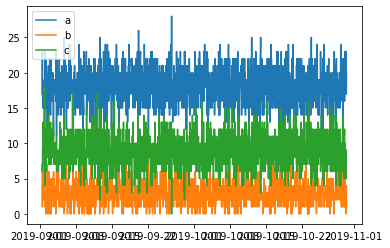

In [8]:
plt.plot(df_currated['unit_a'])
plt.plot(df_currated['unit_b'])
plt.plot(df_currated['unit_c'])
plt.legend(['a', 'b', 'c'])
plt.show()

## Replace NaN to 0

In [9]:
df_currated.fillna(0, inplace=True)

In [10]:
df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_a'].isnull()], df_currated[df_currated['unit_a'].isnull()]

(Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [],
 Empty DataFrame
 Columns: [unit_a, unit_b, unit_c]
 Index: [])

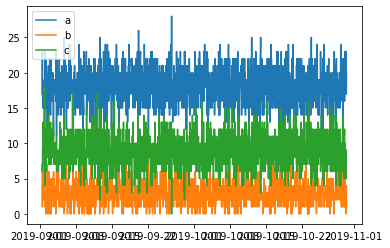

In [11]:
plt.plot(df_currated['unit_a'])
plt.plot(df_currated['unit_b'])
plt.plot(df_currated['unit_c'])
plt.legend(['a', 'b', 'c'])
plt.show()

## RRCF (Initial)

In [12]:
import numpy as np
X = df_currated.to_numpy()
n_points, n_vars = np.shape(X)
n_points, n_vars

(1419, 3)

In [13]:
np.isnan(X).any()

False

In [14]:
# Seed for Repeatebility
np.random.seed(0)

## RRCF Non-Stream

In [15]:
import rrcf

# Construct forest
forest = []

# Specify forest parameters
num_trees = 100
tree_size = int(n_points * 0.125)
sample_size_range = (n_points // tree_size, tree_size)

while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n_points, size=sample_size_range, replace=False)
    
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [16]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n_points))
index = np.zeros(n_points)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [17]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([11, 67, 76, 142, 257, 268, 270, 333, 449, 495, 603, 744, 866, 1048,
            1244],
           dtype='int64')

In [18]:
X[avg_codisp > avg_codisp.quantile(0.99)]

array([[ 9.,  3., 18.],
       [11.,  8., 11.],
       [14.,  9.,  7.],
       [10.,  3., 17.],
       [10.,  3., 17.],
       [15.,  0., 15.],
       [25.,  3.,  2.],
       [11.,  3., 16.],
       [26.,  1.,  3.],
       [11.,  9., 10.],
       [28.,  2.,  0.],
       [11.,  3., 16.],
       [15.,  0., 15.],
       [13.,  1., 16.],
       [14.,  0., 16.]])

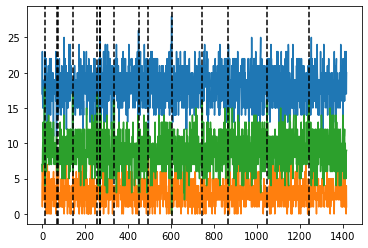

In [19]:
plt.plot(X)
for xc in anom_idx:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

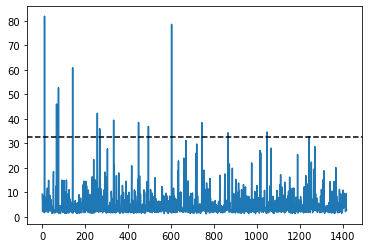

In [20]:
plt.plot(avg_codisp)
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')
plt.show()

## RRCF Stream

In [21]:
# Set tree parameters
num_trees = 100
n_shingle = 8 # lenght of the shingle, using 8 hour as one point
shingle_size = n_shingle # * n_vars
tree_size = 24 * 5 # number of points in the tree for fifo, hour in a day * days

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

In [22]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(X, size=n_shingle)

In [23]:
# transpose
def shingle_transpose(shingle):
    for val in shingle:
        yield val.T.flatten()

points = shingle_transpose(points)

In [24]:
# Create a dict to store anomaly score of each point
avg_codisp = pd.Series(0.0, index=np.arange(n_points + 1 - shingle_size))

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size...
        if len(tree.leaves) > tree_size:
            # Drop the oldest point (FIFO)
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point...
        new_codisp = tree.codisp(index)
        # And take the average over all trees
        avg_codisp[index] += new_codisp / num_trees

In [25]:
anom_idx = (avg_codisp > avg_codisp.quantile(0.99))
anom_idx = anom_idx[anom_idx].index
anom_idx

Int64Index([102, 125, 131, 142, 172, 270, 294, 295, 304, 449, 476, 596, 597,
            598, 602],
           dtype='int64')

In [26]:
# create anom region
def shingle_index_to_range(index, shingle_size):
    return index, [i + shingle_size for i in index] # left_index, rigth_index

def range_to_time_index(left_index, right_index):
#     '''In reading time_index, please ignore the rightmost value of each batch.'''
    time_index = []
    for left, right in zip(left_index, right_index):
        for val in range(left, right):
            if val not in time_index:
                time_index.append(val)
    return time_index

def merge_region(time_index):
    pointer = 0
    left_i = time_index[pointer]
    merged_region = []
    while pointer <= len(time_index):
        counter = 0
        for right_i in time_index[pointer::]:
            if right_i > left_i + counter:
                pointer -= 1
                break
            pointer += 1
            counter += 1
        if pointer >= len(time_index):
            pointer -= 1
            merged_region.append([left_i, time_index[pointer]])
            break
        merged_region.append([left_i, time_index[pointer]])
        left_i = time_index[pointer + 1]
    return merged_region

def get_anomaly_region(index, shingle_size):
    left, right = shingle_index_to_range(index, shingle_size)
    time_index = range_to_time_index(left, right)
    return merge_region(time_index)

anom_regions = get_anomaly_region(anom_idx, shingle_size)
anom_regions

[[102, 109],
 [125, 138],
 [142, 149],
 [172, 179],
 [270, 277],
 [294, 311],
 [449, 456],
 [476, 483],
 [596, 609]]

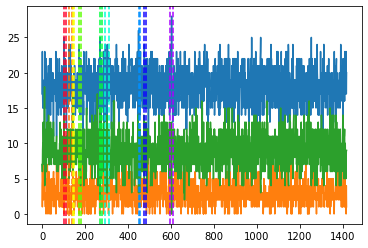

In [27]:
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/len(anom_regions)) for i in range(len(anom_regions))]

plt.plot(X)
for idx, anom_region in enumerate(anom_regions):
    plt.axvline(x=anom_region[0], color=colors[idx], linestyle='--')
    plt.axvline(x=anom_region[1], color=colors[idx], linestyle='--')
# for xc in anom_idx:
#     plt.axvline(x=xc, color='k', linestyle='--')

plt.show()

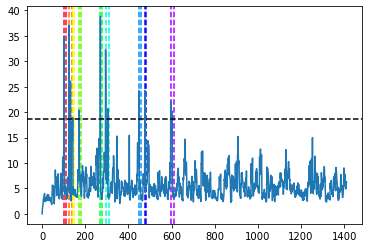

In [28]:
for idx, anom_region in enumerate(anom_regions):
    plt.axvline(x=anom_region[0], color=colors[idx], linestyle='--')
    plt.axvline(x=anom_region[1], color=colors[idx], linestyle='--')
plt.plot(avg_codisp)
plt.axhline(avg_codisp.quantile(0.99), color='k', linestyle='--')

## save model

In [32]:
import dill as pickle
import json
import os
import os.path as osp
folder_result = 'rrcf_power/data/result/'
file_label = ''
if not osp.exists(folder_result):
    os.makedirs(folder_result)
params = {
    'num_trees': num_trees,
    'shingle_size': shingle_size, # five minutes
    'tree_size': tree_size, # number of points in the tree for fifo, minutes in a day
    'data_source_path': data_source_path
}
pickle.dump(forest, open(osp.join(folder_result,'forest'+file_label+'.pickle'), 'wb'))
pickle.dump(avg_codisp, open(osp.join(folder_result,'avg_codispt'+file_label+'.pickle'), 'wb'))
json.dump(params, open(osp.join(folder_result,'params'+file_label+'.json'), 'w'))